# CNN Design in Pytorch for Fashion MNIST Dataset

The <a href='https://www.kaggle.com/zalando-research/fashionmnist'>Fashion-MNIST</a> dataset is available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. This dataset includes:
    - Training set of 60,000 examples
    - Test set of 10,000 examples
Each example is a 28x28 grayscale image, associated with a label from one of the classes below:
0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

## Notebook preparation
### Standard imports
Below cells load the libraries required for this project and the Fashion-MNIST dataset.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

### load the Fashion-MNIST dataset
The Fashion-MNIST dataset is available through <a href='https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist'><tt><strong>torchvision</strong></tt></a>. 

In [2]:
transform = transforms.ToTensor()

# torchvision looks for a local copy of the dataset before downloading it
# If fails to find a local copy, downloading begins
train_data = datasets.FashionMNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='../Data', train=False, download=True, transform=transform)

class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

In [3]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [4]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

## Pipeline
### Create data loaders
In this part, I use DataLoader to create a <tt>train_loader</tt> and a <tt>test_loader</tt> considering batch sizes 10 for both of them. 

In [5]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)

In [38]:
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### View a batch of images
In this part, I display a view of the first batch of 10 images and their labels using <tt>make_grid</tt> in torchvision.

In [6]:
# This line makes the printed array wider
np.set_printoptions(formatter=dict(int=lambda x: f'{x:6}')) 

Label: [     2      7      4      2      1      1      1      1      2      8]
Class: 	 Sweater Sneaker Coat Sweater Trouser Trouser Trouser Trouser Sweater Bag


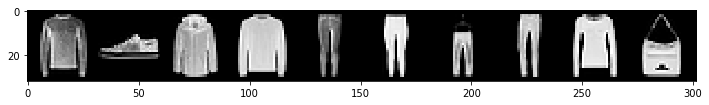

In [10]:
# First batch of training set
for images,labels in train_loader: 
    break

# Display labels
print('Label:', labels.numpy())
print('Class: \t', *np.array([class_names[label] for label in labels]))

# Display the images
# Number of rows is 10 here (default: 8)
im = make_grid(images, nrow=10)
plt.figure(figsize=(12,4))
# Transpose the tensor in order to display it here (the depth would be the last dimension in here)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

<div style='border:1px black solid; padding:5px'>
    Most convolutional neural network follow this trend of having a convolutonal layer, then pooling layer, and repeating this until having fully connected layers at the end. 
    
    Note that if we have 2D images of size NxN and pass it through a convolutional layer using fxf size filters, padding of size p, and stride of s then the resulting matrix size can be calculated as:

\begin{equation*}
\newcommand{\floor}[1]{\lfloor #1 \rfloor} 
\floor{\frac{N + 2p -f}{s}} + 1, \\     \floor{\frac{N + 2p -f}{s}}
+ 1
\end{equation*}
- Stride s tells us the number of pixels we jump over when we are convolving filters. 
<br>
    
Let's consider an example image of 28x28 that is passed through a convolutional layer using 3x3 filters with a step size of 1 and no padding. Acoording to the above formula this convolutional operation results in 26x26 matrix size. Let's check this in below code:
</div>

In [11]:
conv = nn.Conv2d(1, 1, 3, 1)  #in_channel=1, out_channel=1, kernel_size=3, stride=1
for x,labels in train_loader:
    print('Original size:',x.shape)
    break
x = conv(x)
print('Size after conv:',x.shape)

Original size: torch.Size([10, 1, 28, 28])
Size after conv: torch.Size([10, 1, 26, 26])


<div style='border:1px black solid; padding:5px'>
    Other than the convolutional layers, pooling layers are also very useful in CNNs to reduce the size of the tensors and speed up the computations. They also perform feature detections to find more robust models. 
As an example, if we apply a 2x2 pooling layer to the result of the previous convolutional layer, it devides the size of the matrix by half, if we have stride of 2; therefore, the result would be 13x13. 
    <br>
The calculations are shown in below code:
</div>

In [12]:
# Pooling layer, 2x2 filters with stride of 2
x = F.max_pool2d(x, 2, 2)
print('Down size:',x.shape)

Down size: torch.Size([10, 1, 13, 13])


### Convolutional neural network definition
In this section, I define a the CNN model that I want to train on the Fashion-MNIST dataset. My model contains CONV -> RELU -> POOL -> CONV -> RELU -> POOL -> FC -> RELU -> FC:
- Two convolutional layers
- Two pooling layers 
- Two fully connected layers

This model takes 28x28 images as input and will have output layer of size 10.

<div class="alert alert-info"><strong>We follow these steps to create a CNN model.</strong><br>

1. Extend the base Module class at the beginning:
   
<tt><font color=black>class ConvolutionalNetwork(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Create convolutional layers with <a href='https://pytorch.org/docs/stable/nn.html#conv2d'><tt><strong>torch.nn.Conv2d()</strong></tt></a><br><br>A. The first layer has one input channel as it is grayscale. I perform feature extraction by applying 6 output channels. I use a kernel size of 3x3 to make filters, with a stride of 1.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv1 = nn.Conv2d(1, 6, 3, 1)</font></tt><br>
B. Afterward, the second layer takes 6 input channels and deliver 16 output channels.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv2 = nn.Conv2d(6, 16, 3, 1)</font></tt><br><br>

3. Create the fully connected layers with <a href='https://pytorch.org/docs/stable/nn.html#linear'><tt><strong>torch.nn.Linear()</strong></tt></a>.<br><br> Calculating the input size of the fully connected layer would be $\;(((28-2)/2)-2)/2 = 5.5\;$ which rounds down to a 5x5 input. To be more specific, the first convolutional layer leaves a one-pixel edge at each side (therefore two pixels vertically, and two pixels horizantally. As a result, we have 26x26 images after convolutonal layer without performing padding. As the borders of this dataset manily contains black pixels, performing padding is not required here. By applying pooling layer the size of the tensor will shrink in half, when 3x3 filters are applied using stride of 2. The size of the next fully connected layer is chosen as a common choice practice in similar datasets. <br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc1 = nn.Linear(5\*5\*16, 120)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc2 = nn.Linear(120, 84)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc3 = nn.Linear(84, 10)</font></tt><br>

4. Design the forward method.<br><br> A. We apply acticvation functions to the convolutions using <a href='https://pytorch.org/docs/stable/nn.html#id27'><tt><strong>F.relu()</strong></tt></a>. Also, max pooling layers are designed using <a href='https://pytorch.org/docs/stable/nn.html#maxpool2d'><tt><strong>F.max_pool2d()</strong></tt></a><br>
<tt><font color=black>def forward(self, X):<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv2(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
</font></tt>B. Flatten the data for the fully connected layers:<br><tt><font color=black>
&nbsp;&nbsp;&nbsp;&nbsp;X = X.view(-1, 5\*5\*16)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.fc1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = self.fc2(X)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return F.log_softmax(X, dim=1)</font></tt>
</div>

In [51]:
class MyCNN(nn.Module):
    # Extend the base model class
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1) # 6 output channels
        self.conv2 = nn.Conv2d(6, 16, 3, 1) #16 output channels
        self.fc1 = nn.Linear(5*5*16, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2) # pooling kernel size=2, stride = 2
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2) # pooling kernel size=2, stride = 2
        X = X.view(-1, 5*5*16) # Flatten the matrix to feed a fully connected layer
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)
    
torch.manual_seed(24)
model = MyCNN()

The model looks like below:

In [52]:
model

MyCNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

CNNs are used to decrease the computational overhead of processing big images by introducing convolutional layers and pooling layers that decrease the number of parameters in the model significantly. In this specific model here, we can find the number of the parameters (including the bias terms) in the model as below:

<div style='padding:5px'>
$\quad\begin{split}(1\times6\times3\times3)+6+(6\times16\times3\times3)+16+(400\times100)+100+(100\times10)+10 &=\\
54+6+864+16+40000+100+1000+10 &= 42,050\end{split}$<br>
</div>

In [48]:
def count_parameters(model):
    params = [param.numel() for param in model.parameters() if param.requires_grad]
    print(params)
    print(f' \nsum: {sum(params)}')

In [49]:
count_parameters(model)

[54, 6, 864, 16, 40000, 100, 1000, 10]
 
sum: 42050


### Loss function and optimizer
In this part, I define a loss function that is called "criterion" and an optimizer called "optimizer"
using Cross Entropy Loss and Adam (learning rate of 0.001).

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training the model

In this section we feed the data directly into the model to train it.

In [55]:
import time
start = time.time()

# Number of epochs 
epochs = 5
train_loss = []
test_loss = []
train_true = []
test_true = []

for e in range(epochs):
    tr_true = 0
    ts_true = 0
    # Perform training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b = b + 1 
        
        # Predict the train data using the model (no need to flatten X-train here)
        y_pred = model(X_train)  
        loss = criterion(y_pred, y_train)
        
        # The amount of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_true = (predicted == y_train).sum()
        tr_true += batch_true
        
        # Update the parameters in the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%1000 == 0:
            print(f'epoch {e:2},  batch {b:4} -> loss: {loss.item():10.8f}  accuracy: {tr_true.item()*100/(10*b):7.3f}%')
        
    train_loss.append(loss)
    train_true.append(tr_true)
        
    # The batches in the test set
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # The model from training
            y_val = model(X_test)

            # The correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            ts_true += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_loss.append(loss)
    test_true.append(ts_true)
    
# The time elapsed         
print(f'\nDuration to train and test the model: {time.time() - start:.0f} seconds')            

epoch  0,  batch 1000 -> loss: 0.36906940  accuracy:  72.040%
epoch  0,  batch 2000 -> loss: 0.08695976  accuracy:  76.290%
epoch  0,  batch 3000 -> loss: 0.07228963  accuracy:  78.540%
epoch  0,  batch 4000 -> loss: 0.15724052  accuracy:  80.028%
epoch  0,  batch 5000 -> loss: 0.15887776  accuracy:  81.066%
epoch  0,  batch 6000 -> loss: 0.40527382  accuracy:  81.887%
epoch  1,  batch 1000 -> loss: 0.57526886  accuracy:  86.260%
epoch  1,  batch 2000 -> loss: 0.17887256  accuracy:  86.625%
epoch  1,  batch 3000 -> loss: 0.08559704  accuracy:  86.873%
epoch  1,  batch 4000 -> loss: 0.01638916  accuracy:  87.043%
epoch  1,  batch 5000 -> loss: 0.20932522  accuracy:  87.180%
epoch  1,  batch 6000 -> loss: 0.25373715  accuracy:  87.250%
epoch  2,  batch 1000 -> loss: 0.24757957  accuracy:  89.030%
epoch  2,  batch 2000 -> loss: 0.12466985  accuracy:  88.900%
epoch  2,  batch 3000 -> loss: 0.20957537  accuracy:  88.923%
epoch  2,  batch 4000 -> loss: 0.54517877  accuracy:  88.748%
epoch  2

### Plot of loss and accuracy during training

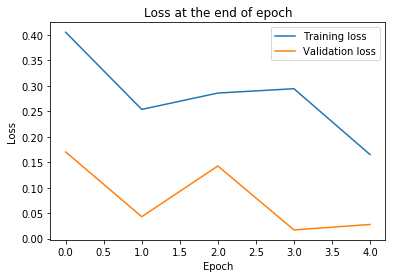

In [59]:
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Validation loss')
plt.title('Loss at the end of epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

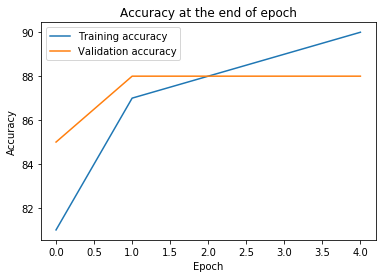

In [62]:
plt.plot([t/600 for t in train_true], label='Training accuracy')
plt.plot([t/100 for t in test_true], label='Validation accuracy')
plt.title('Accuracy at the end of epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

We see that the training accuracy increases aftet each epoch, but validation accuracy does not change much after the second epoch so the model may start to overfit. 

### Evaluate the model on the test data
USing <tt>model.eval()</tt> I determine the percentage correct predicted images out of 10,000 total test data.

In [70]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [74]:
model.eval()

# No backpropagation requierd while testing
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 8886/10000 =  88.860%


### Confusion matrix

In [100]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print("\n")
# confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]


[[ 872    5   17   19    3    1  146    0    3    1]
 [   1  972    1   11    1    0    2    0    1    0]
 [  22    0  863   11  119    0  101    0    6    0]
 [  12   15   10  908   35    1   20    0    2    0]
 [   2    2   39   23  759    0   60    0    3    0]
 [   1    0    0    0    0  980    0   16    3   10]
 [  86    4   65   26   82    0  658    0    2    0]
 [   0    0    0    0    0   12    0  975    6   64]
 [   4    2    5    2    1    0   13    0  974    0]
 [   0    0    0    0    0    6    0    9    0  925]]


In order to get more information from the confusion matrix, let's define a function to plot the confusion matrix that shows which labels are more accurate for our model to predict. 

In [106]:
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions


    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
    
    """

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(10, 7.5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

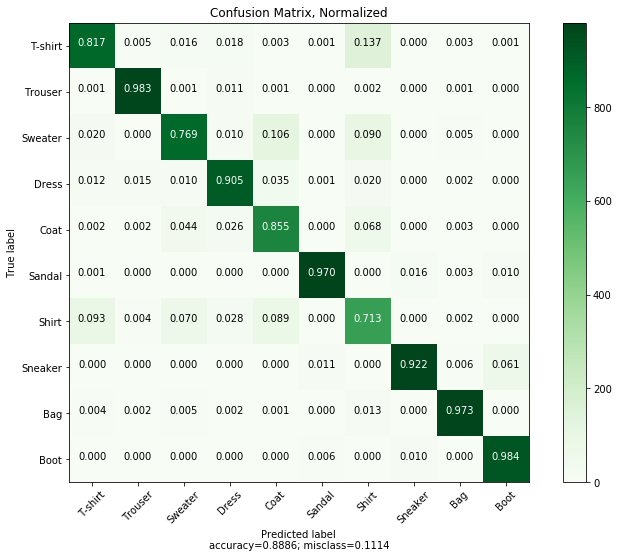

In [115]:
cm = confusion_matrix(predicted.view(-1), y_test.view(-1))

plot_confusion_matrix(cm, normalize    = True,
                      target_names = class_names,
                      title        = "Confusion Matrix, Normalized")

#### Results
- According to the confusion matrix, classes **trouser**, **dress**, **sandal**, **sneaker**, **bag**, and **boot** can be classified better using this model.  On the other hand, we can see that **T-shirt** can be classified as "sneaker" in this mode by mistake. 

- **Sweater** can also be classified as "coat" or "shirt" class by mistake. 

- **Coat** can be classified as "shirt" wrongly. 

- **Shirt** is the least accurate class and can be mistaken with "T-shirt", "Sweater" or even "Coat" class. 